## create non fire points

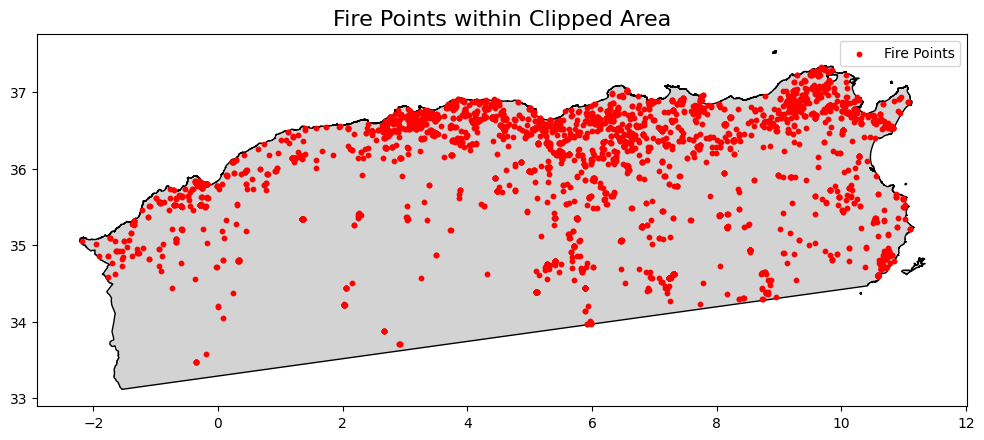

Clipped fire points saved to CSV: /content/drive/MyDrive/data_set/fire/fire_vege_clipped.csv
Number of points saved: 3099


In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# --- Paths ---
fire_csv = "/content/drive/MyDrive/data_set/fire/fire_vege.csv"
clipped_path = "/content/drive/MyDrive/data_set/clipped_final.geojson"
fire_clipped_csv = "/content/drive/MyDrive/data_set/fire/fire_vege_clipped.csv"

# --- Load fire points ---
fire_df = pd.read_csv(fire_csv)
fire_gdf = gpd.GeoDataFrame(
    fire_df,
    geometry=gpd.points_from_xy(fire_df.longitude, fire_df.latitude),
    crs="EPSG:4326"
)

# --- Load clipped area ---
clipped_gdf = gpd.read_file(clipped_path).to_crs("EPSG:4326")

# --- Spatial join: keep only points inside the polygon ---
if 'index_right' in fire_gdf.columns:
    fire_gdf = fire_gdf.drop(columns=['index_right'])

fire_clipped_gdf = gpd.sjoin(
    fire_gdf,
    clipped_gdf,
    predicate='within',
    how='inner',
    rsuffix='clip'
)

# --- Add fire column ---
fire_clipped_gdf['fire'] = 1

# --- Keep only geometry and fire columns ---
fire_clipped_gdf = fire_clipped_gdf[['geometry', 'fire']]

# --- Extract longitude and latitude if needed ---
fire_clipped_gdf['longitude'] = fire_clipped_gdf.geometry.x
fire_clipped_gdf['latitude'] = fire_clipped_gdf.geometry.y

# --- Save to CSV ---
fire_clipped_gdf[['longitude', 'latitude', 'fire']].to_csv(fire_clipped_csv, index=False)

# --- Plot for verification ---
fig, ax = plt.subplots(figsize=(12, 12))
clipped_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
fire_clipped_gdf.plot(ax=ax, color='red', markersize=10, label='Fire Points')
ax.set_title("Fire Points within Clipped Area", fontsize=16)
ax.legend()
plt.show()

print(f"Clipped fire points saved to CSV: {fire_clipped_csv}")
print(f"Number of points saved: {len(fire_clipped_gdf)}")


In [ ]:
duplicate_count = fire_clipped_gdf.duplicated(subset="geometry").sum()
print("Number of duplicate points:", duplicate_count)


Number of duplicate points: 0


/tmp/ipython-input-1761834199.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cand_gdf = cand_gdf[cand_gdf.within(clipped_proj.unary_union)]


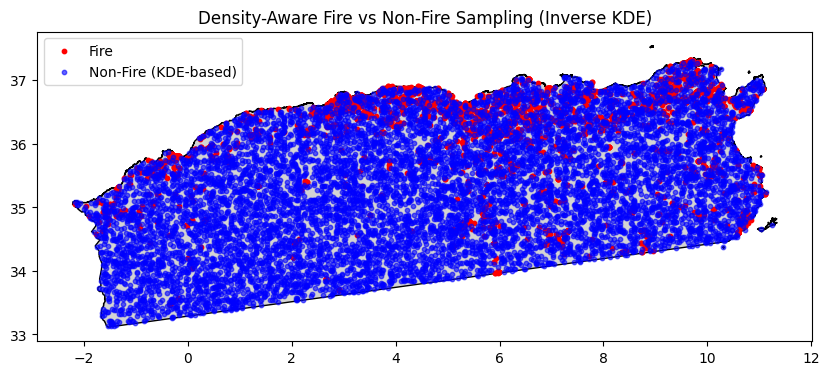

File exists: True
Saved 9297 inverse-KDE non-fire points.


In [ ]:
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import os

# --- Load your existing data ---
# fire_gdf = gpd.read_file("/content/drive/MyDrive/data_set/fire/fire_vege.csv")
# clipped_gdf = gpd.read_file("/content/drive/MyDrive/data_set/clipped.geojson")

# --- Reproject to projected CRS (meters, so KDE uses real distances) ---
fire_proj = fire_clipped_gdf.to_crs(epsg=3857)
clipped_proj = clipped_gdf.to_crs(epsg=3857)

# --- KDE fitting ---
coords = np.vstack([fire_proj.geometry.x, fire_proj.geometry.y]).T
kde = KernelDensity(bandwidth=2000, kernel='gaussian')  # bandwidth in meters (try 3–10 km)
kde.fit(coords)

# --- Build candidate grid inside clipped area ---
minx, miny, maxx, maxy = clipped_proj.total_bounds
x_res, y_res = 2000, 2000  # grid step in meters
x_coords = np.arange(minx, maxx, x_res)
y_coords = np.arange(miny, maxy, y_res)
xx, yy = np.meshgrid(x_coords, y_coords)
candidate_points = [Point(x, y) for x, y in zip(xx.ravel(), yy.ravel())]
cand_gdf = gpd.GeoDataFrame(geometry=candidate_points, crs=clipped_proj.crs)
cand_gdf = cand_gdf[cand_gdf.within(clipped_proj.unary_union)]

# --- Evaluate KDE at each candidate point ---
cand_coords = np.vstack([cand_gdf.geometry.x, cand_gdf.geometry.y]).T
log_dens = kde.score_samples(cand_coords)
dens = np.exp(log_dens)
cand_gdf['fire_density'] = dens

# --- Inverse-density weighting (more samples where fire density is low) ---
cand_gdf['weight'] = 1 / (cand_gdf['fire_density'] + 1e-9)
cand_gdf['weight'] /= cand_gdf['weight'].sum()

# --- Sample non-fire points (same number as fires) ---
n_samples = 3*len(fire_proj)
non_fire_gdf = cand_gdf.sample(n=n_samples, weights='weight', replace=False, random_state=42)

# --- Label datasets ---
fire_proj['fire'] = 1
non_fire_gdf['fire'] = 0

# --- Merge back to geographic coordinates ---
non_fire_gdf = non_fire_gdf.to_crs(epsg=4326)
fire_geo = fire_proj.to_crs(epsg=4326)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,10))
clipped_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
fire_geo.plot(ax=ax, color='red', markersize=10, label='Fire')
non_fire_gdf.plot(ax=ax, color='blue', markersize=10, alpha=0.6, label='Non-Fire (KDE-based)')
ax.legend()
plt.title("Density-Aware Fire vs Non-Fire Sampling (Inverse KDE)")
plt.show()

# --- Save results ---
output_path = "/content/drive/MyDrive/data_set/fire/non_fire_kde_inv.csv"
non_fire_gdf.to_csv(output_path, index=False)
print("File exists:", os.path.exists(output_path))
print(f"Saved {len(non_fire_gdf)} inverse-KDE non-fire points.")


In [ ]:
# --- Check for overlap ---
overlap = non_fire_gdf.geometry.apply(lambda p: fire_geo.geometry.contains(p).any())
num_overlap = overlap.sum()

print(f"Number of non-fire points that overlap with fire points: {num_overlap}")

# Optionally, display these points
if num_overlap > 0:
    overlapping_points = non_fire_gdf[overlap]
    print(overlapping_points)


Number of non-fire points that overlap with fire points: 0


## combine fire and non fire

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# --- Paths ---
fire_path = "/content/drive/MyDrive/data_set/fire/fire_vege_clipped.csv"
non_fire_path = "/content/drive/MyDrive/data_set/fire/non_fire_kde_inv.csv"

# --- Load fire points CSV and create fire column ---
fire_df = pd.read_csv(fire_path)
fire_df['fire'] = 1  # mark all fire points as fire

# --- Create geometry from longitude/latitude ---
fire_gdf = gpd.GeoDataFrame(
    fire_df[['fire']],
    geometry=[Point(xy) for xy in zip(fire_df.longitude, fire_df.latitude)],
    crs="EPSG:4326"
)

# --- Load non-fire points CSV ---
non_fire_df = pd.read_csv(non_fire_path)

# --- Convert non-fire points to GeoDataFrame ---
from shapely import wkt

if 'geometry' not in non_fire_df.columns:
    non_fire_gdf = gpd.GeoDataFrame(
        non_fire_df[['fire']],
        geometry=[Point(xy) for xy in zip(non_fire_df.longitude, non_fire_df.latitude)],
        crs="EPSG:4326"
    )
else:
    non_fire_gdf = gpd.GeoDataFrame(
        non_fire_df[['fire']],
        geometry=non_fire_df['geometry'].apply(wkt.loads),
        crs="EPSG:4326"
    )

# --- Combine fire and non-fire points ---
combined_gdf = pd.concat([fire_gdf, non_fire_gdf], ignore_index=True)

# --- Keep only geometry and fire columns ---
combined_gdf = combined_gdf[['geometry', 'fire']]

# --- Save to CSV ---
combined_gdf.to_csv("/content/drive/MyDrive/data_set/fire/merged/combined_fire_nonfire.csv", index=False)

print(f"Combined dataset saved. Total points: {len(combined_gdf)}")


Combined dataset saved. Total points: 12396


# Final Class distribution

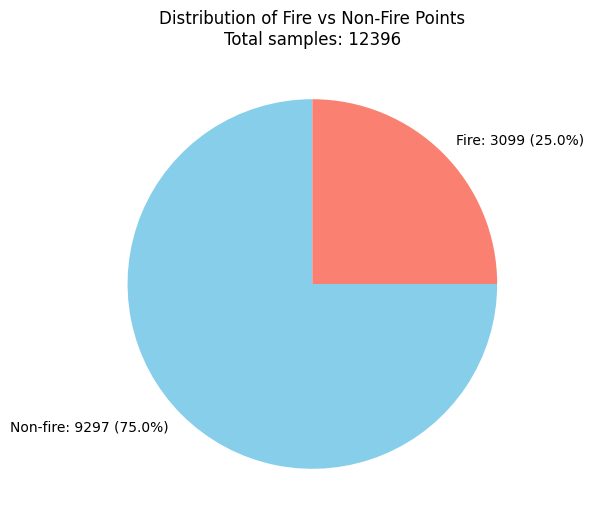

Total samples: 12396
fire
0    9297
1    3099
Name: count, dtype: int64
fire
0    75.0
1    25.0
Name: count, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("/content/drive/MyDrive/data_set/fire/merged/combined_fire_nonfire.csv")

# Count the number of samples per class
counts = df['fire'].value_counts().sort_index()  # 0 = non-fire, 1 = fire
total = counts.sum()

# Calculate percentages
percentages = counts / total * 100

# Create labels with counts and percentages
labels = [f"Non-fire: {counts[0]} ({percentages[0]:.1f}%)",
          f"Fire: {counts[1]} ({percentages[1]:.1f}%)"]

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='', colors=['skyblue', 'salmon'], startangle=90)
plt.title(f"Distribution of Fire vs Non-Fire Points\nTotal samples: {total}")
plt.show()

# Print total samples
print(f"Total samples: {total}")
print(counts)
print(percentages.round(2))
